# Learning Through Target Bursts (LTTB) - Figure 1

This notebook reproduces the results presented in `Figure 1` of the <a href="https://arxiv.org/abs/2201.11717">arXiv 2201.11717</a> preprint paper: Cristiano Capone<sup>\*</sup>, Cosimo Lupo<sup>\*</sup>, Paolo Muratore, Pier Stanislao Paolucci (2022) "*Burst-dependent plasticity and dendritic amplification support target-based learning and hierarchical imitation learning*". We test the `LTTB` model on a 3D-trajectory task.

Please give credit to this paper if you use or modify the code in a derivative work. This work is licensed under the Creative Commons Attribution 4.0 International License. To view a copy of this license, visit http://creativecommons.org/licenses/by/4.0/ or send a letter to Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

### Libraries Import & Parameter Loading

In this section we import the needed external libraries and load the model parameters for this task (via the `json` configuration file).

In [1]:
import json
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange

import lttb as lttb_module

In [2]:
with open ('./config.json', 'r') as fp:
    par = json.load(fp)['FIGURE_1']

n_contexts = par['n_contexts']
T = par['T']
dt = par['dt']
tau_m = par['tau_m']
eta = par['eta']
eta_out = par['eta_out']

gamma = 1./par['du']
def f(x,gamma):
    return np.exp(x*gamma)/(np.exp(x*gamma)+1)

### Function Definitions

In this section we define several useful functions that will be used during the experiments.

In [3]:
# * Define clock and target
def init_clock_targ():
    
    lttb.y_targ_collection = []
    
    for k in range(n_contexts):
        lttb.init_targ(par)
        lttb.y_targ_collection.append(lttb.y_targ)
    
    
    lttb.init_clock(par)

# * -------------- TESTING FUNCTIONS --------------------
def short_test():
    
    mses = np.zeros(n_contexts)
    
    for cont_index in range(n_contexts):
    
        lttb.cont = lttb.cont*0
        lttb.cont[cont_index] = 1
        lttb.y_targ = lttb.y_targ_collection[cont_index]
        lttb.initialize(par)
    
        #run simulation
        for t in range(lttb.T-2):
            lttb.step(apicalFactor = 0)

        SR = lttb.B_filt_rec[:,1:-2]
        Y = lttb.Jout@SR + np.tile(lttb.Bias,(lttb.T-3,1)).T
        mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2
        mses[cont_index] = mse_rec_train
    
    return mses

def full_test():
    
    stats = {}
    
    stats['targs'] = []
    stats['outputs'] = []
    stats['contexts'] = []
    stats['S_somas'] = []
    stats['S_winds'] = []
    stats['mses'] = np.zeros(n_contexts)
    if n_contexts==2:
        stats['mses_offDiag'] = np.zeros(n_contexts)
    
    for cont_index in range(n_contexts):
        
        context = np.zeros((lttb.T-2,n_contexts))
        context[:,cont_index] = np.array([1 for _ in range(lttb.T-2)])
        lttb.y_targ = lttb.y_targ_collection[cont_index]
        lttb.initialize(par)

        #run simulation
        for t in range(lttb.T-2):
            lttb.cont = context[t]
            lttb.step(apicalFactor = 0)

        SR = lttb.B_filt_rec[:,1:-2]
        Y = lttb.Jout@SR + np.tile(lttb.Bias,(lttb.T-3,1)).T
        
        stats['outputs'].append(Y)
        stats['contexts'].append(context)
        stats['S_somas'].append(lttb.S_soma)
        stats['S_winds'].append(lttb.S_wind)
        stats['targs'].append(lttb.y_targ[:,1:-2])
        stats['mses'][cont_index] = np.std(lttb.y_targ[:,1:-2] - Y)**2
        if n_contexts==2:
            wrong_targ = lttb.y_targ_collection[1-cont_index][:,1:-2]
            stats['mses_offDiag'][cont_index] = np.std(wrong_targ - Y)**2
    
    return stats

# * --------------------- TRAINING FUNCTION --------------------------------
def training(nIterRec=100, test_every=5, eta=5., eta_out=0.01, etaW=0., eta_bias=0.0002, verbose = True):
    
    ERRORS = np.zeros((int(nIterRec/test_every),n_contexts))
    
    iterator = trange(nIterRec, desc = 'LTTB Training', leave = True)

    for iteration in iterator:
    
        #initialize simulation
        
        for cont_index in range(n_contexts):
        
            lttb.cont = lttb.cont*0
            lttb.cont[cont_index] = 1
            lttb.y_targ = lttb.y_targ_collection[cont_index]
            lttb.initialize(par)
    
            #run simulation
            dH = 0
            for t in range(lttb.T-2):
                lttb.step(apicalFactor = 1)
    
                dH = dH*(1-dt/tau_m) + dt/tau_m*lttb.S_filt[:,t]
                DJ = np.outer( ( lttb.S_apic_dist[:,t+1] - f(lttb.VapicRec[:,t],gamma) )*(1-lttb.S_apic_prox[:,t])*lttb.S_wind_soma[:,t+1] ,dH)
                lttb.J =  lttb.J + eta*DJ
    
                SR = lttb.B_filt_rec[:,t+1]
                Y = lttb.Jout@SR + lttb.Bias
                DJRO = np.outer(lttb.y_targ[:,t+1] - Y,SR.T)
                dBias = lttb.y_targ[:,t+1] - Y
                lttb.Jout = lttb.Jout + eta_out*DJRO
                lttb.Bias = lttb.Bias + eta_bias*dBias
        
        ###### Test
        
        if (iteration+1)%test_every==0:
            
            mses = short_test()
            
            ERRORS[int(iteration/test_every),:] = mses
            
            if verbose:
                msg = 'LTTB Training. MSEs: ' + ''.join([f'{mse:.4f} | ' for mse in mses])
                iterator.set_description(msg)

    return ERRORS

### Model Initialization

In [5]:
lttb = lttb_module.LTTB(par)
init_clock_targ()

### Model Training

In this section we train the model via the `training` function on the `3D Trajectory` task.

In [6]:
nEpochs = 5

for epoch in range(nEpochs):
    ERRORS = training(nIterRec=100, eta=eta, eta_out=eta_out, eta_bias=0, verbose = True)

LTTB Training. MSEs: 0.1992 | : 100%|██████████| 100/100 [02:42<00:00,  1.63s/it]
LTTB Training. MSEs: 0.1380 | : 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]
LTTB Training. MSEs: 0.1157 | : 100%|██████████| 100/100 [03:08<00:00,  1.89s/it]
LTTB Training. MSEs: 0.0588 | : 100%|██████████| 100/100 [03:06<00:00,  1.87s/it]
LTTB Training. MSEs: 0.0326 | : 100%|██████████| 100/100 [03:06<00:00,  1.86s/it]


### Testing the Model

In this section we perform a `full_test` of the model and collect the results for visualization.

In [7]:
res = full_test()

cont_index = 0

contexts = res['contexts']
context = contexts[cont_index]
Y = res['outputs'][cont_index]
targ = res['targs'][cont_index]
S_soma = res['S_somas'][cont_index]
S_wind = res['S_winds'][cont_index]

M1 = [S_soma[i][j] if S_wind[i][j]==0 else 0 for i in range(len(S_soma)) for j in range(len(S_soma[i]))]
M2 = [S_soma[i][j] if S_wind[i][j]>0 else 0 for i in range(len(S_soma)) for j in range(len(S_soma[i]))]
M1 = np.array(M1).reshape(np.shape(S_soma))
M2 = np.array(M2).reshape(np.shape(S_soma))

v1 = []
v2 = []
for i in range(np.shape(S_soma)[0]):
    for j in range(np.shape(S_soma)[1]):
        if(M1[i][j]>0):
            v1.append(i)
            v2.append(j)

w1 = []
w2 = []
for i in range(np.shape(S_soma)[0]):
    for j in range(np.shape(S_soma)[1]):
        if(M2[i][j]>0):
            w1.append(i)
            w2.append(j)

### Results Visualization

In this section we compose the final visualization used in `Figure_1` of the paper.

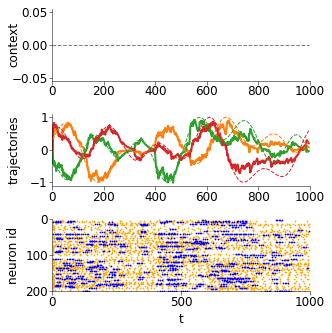

In [8]:
fs = 12
cm = 1/2.54  # centimeters in inches
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12*cm, 12*cm))

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=fs, pad=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)

ax = axes[0]
if (par['sigma_apical_cont']==0 and par['sigma_basal_cont']==0):
    for d in range(n_contexts):
        ax.plot(0.*context.T[d], zorder=1, ls='--', color=['black','red'][d], lw=1, alpha=0.5)
else:
    for d in range(n_contexts):
        ax.plot(context.T[d], zorder=1, ls='--', color=['black','red'][d], lw=1, alpha=0.5)
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([0,1000])
ax.text(-0.15, 0.5, 'context', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')
    
ax = axes[1]
for d in range(par['O']):
    ax.plot(np.array(Y)[d].T, zorder=0, color='C' + str(d+1), lw=2)
for d in range(par['O']):
    ax.plot(np.array(targ)[d].T, zorder=1, ls='--', color='C' + str(d+1), lw=1)
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([0,1000])
ax.text(-0.15, 0.5, 'trajectories', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')

ax = axes[2]
cmap1 = matplotlib.colors.ListedColormap(['None','orange'], name='colors', N=None)
cmap2 = matplotlib.colors.ListedColormap(['None','blue'], name='colors', N=None)
for i in range(len(v1)):
    if(v1[i]>2 and v1[i]<199 and v2[i]>2 and v2[i]<999):
        y = v1[i]
        ax.scatter(v2[i], y, color='orange', marker='.', s=2)
for i in range(len(w1)):
    if(w1[i]>1 and w1[i]<200 and w2[i]>2 and w2[i]<999):
        y = w1[i]
        ax.scatter(w2[i], y, color='blue', marker='.', s=2)
ax.set_xlabel('t', fontsize=fs)
ax.set_ylabel('', fontsize=fs)
ax.set_xlim([0,1000])
ax.set_ylim([200,0])
ax.set_xticks([0,500,1000])
ax.set_yticks([200,100,0])
ax.text(-0.15, 0.5, 'neuron id', fontsize=fs, ha='center', va='center', rotation=90, \
        transform=ax.transAxes, rotation_mode='anchor')

plt.tight_layout()
#plt.subplots_adjust(left=0.23, bottom=0.12, right=0.93, top=0.95, wspace=None, hspace=0.4)

plt.show()